# Imports

In [240]:
import pickle
import spacy
import time
import nltk.data
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from codecarbon import EmissionsTracker

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\josem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Utils

## Reading Models

In [241]:
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
nlp = spacy.load("en_core_web_sm")

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Utils for text extraction

In [242]:
def extract_names(text):
    doc = nlp(text)  # Process the text with spaCy
    return [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
# Function to extract subjects
def extract_subject(text):
    doc = nlp(text)
    return [token.text for token in doc if token.dep_ == "nsubj"]
def eth_by_text(df, dict_eth):
    racis_eth = ['ind', 'spa', 'kor', 'chi', 'jap']
    eth_ = []
    for text in df.text:
        list_eth = []
        for name, ethn in dict_eth.items():
            if name in text and ethn in racis_eth:
                list_eth.append(ethn)
        if list_eth:
            eth_.append(" ".join(list_eth))
        else:
            eth_.append('na')
    return eth_

# Read Data

In [243]:
# Load data
df_train = pd.read_csv('data/EMGSD_train.csv')
df_test = pd.read_csv('data/EMGSD_test.csv')

# Featurize Data

### Similarity

In [244]:

try: 
    with open('embeddings/embeddings.pickle', 'rb') as handle:
        embeddings = pickle.load(handle)
except:
    embeddings = {stype: sentence_transformer.encode(df_train[df_train.stereotype_type == stype]['text'].tolist(), show_progress_bar=True) for stype in df_train.stereotype_type.unique()}
    with open('embeddings/embeddings.pickle', 'wb') as handle:
        pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
distributions = {stype: {'mean': np.mean(embeddings[stype], axis=0).reshape(-1,1)} for stype in df_train.stereotype_type.unique()}
try:
    train_similarity = pd.read_csv('data/featurized_data/similarity_train.csv')
except:
    similarity = [{stype: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions[stype]['mean'].T).item() for stype in distributions} for text in df_train.text]
    train_similarity = pd.DataFrame(similarity)
    train_similarity.to_csv('data/featurized_data/similarity_train.csv', index=False)

In [245]:
try: 
    with open('embeddings/embeddings_cat.pickle', 'rb') as handle:
        embeddings = pickle.load(handle)
except:
    embeddings = {cat: sentence_transformer.encode(df_train[df_train.category == cat]['text'].tolist(), show_progress_bar=True) for cat in df_train.category.unique()}
    with open('embeddings/embeddings_cat.pickle', 'wb') as handle:
        pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
distributions_cat = {cat: {'mean': np.mean(embeddings[cat], axis=0).reshape(-1,1)} for cat in df_train.category.unique()}
try:
    train_similarity_cat = pd.read_csv('data/featurized_data/similarity_cat_train.csv')
except:
    similarity_cat = [{cat: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions_cat[cat]['mean'].T).item() for cat in distributions_cat} for text in df_train.text]
    train_similarity_cat = pd.DataFrame(similarity_cat)
    train_similarity_cat.to_csv('data/featurized_data/similarity_cat_train.csv', index=False)

In [246]:
try:
    test_similarity = pd.read_csv('data/featurized_data/similarity_test.csv')
except:
    similarity_test = [{stype: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions[stype]['mean'].T).item() 
                        for stype in distributions} for text in df_test.text]
    test_similarity = pd.DataFrame(similarity_test)
    test_similarity.to_csv('data/featurized_data/similarity_test.csv', index=False)

In [247]:
try:
    test_similarity_cat = pd.read_csv('data/featurized_data/similarity_cat_test.csv')
except:
    similarity_cat_test = [{cat: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions_cat[cat]['mean'].T).item() 
                        for cat in distributions_cat} for text in df_test.text]
    test_similarity_cat = pd.DataFrame(similarity_cat_test)
    test_similarity_cat.to_csv('data/featurized_data/similarity_cat_test.csv', index=False)

# Model

## Stereotype Model

### Vectorize

In [248]:
# Create TF-IDF features
label = 'stereotype_type'
vectorizer_ste = TfidfVectorizer()
X_fidf = vectorizer_ste.fit_transform(df_train['text'])
X = hstack([X_fidf, train_similarity])
y = df_train[label].str.replace('unrelated','neutral')

### Train and Validate Model

In [249]:
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.05, random_state=0)

In [250]:
min_data_in_leaf = 2
# Train LightGBM
lgb_model_ste = lgb.LGBMClassifier(random_state = 42, force_col_wise = True, min_data_in_leaf = min_data_in_leaf)
lgb_model_ste.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Total Bins 112181
[LightGBM] [Info] Number of data points in the train set: 43472, number of used features: 10503
[LightGBM] [Info] Start training from score -2,209561
[LightGBM] [Info] Start training from score -2,869520
[LightGBM] [Info] Start training from score -0,798324
[LightGBM] [Info] Start training from score -1,079654
[LightGBM] [Info] Start training from score -4,718867
[LightGBM] [Info] Start training from score -3,358023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(force_col_wise=True, min_data_in_leaf=2, random_state=42)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

Classification Report:
              precision    recall  f1-score   support

      gender       0.97      0.94      0.95       248
      lgbtq+       0.99      1.00      1.00       121
 nationality       0.97      0.99      0.98      1018
  profession       0.97      0.97      0.97       793
        race       0.81      0.45      0.58        29
    religion       0.96      0.96      0.96        79

    accuracy                           0.97      2288
   macro avg       0.95      0.88      0.91      2288
weighted avg       0.97      0.97      0.97      2288

F1 Score:
0.9067975421742894
Confusion Matrix:


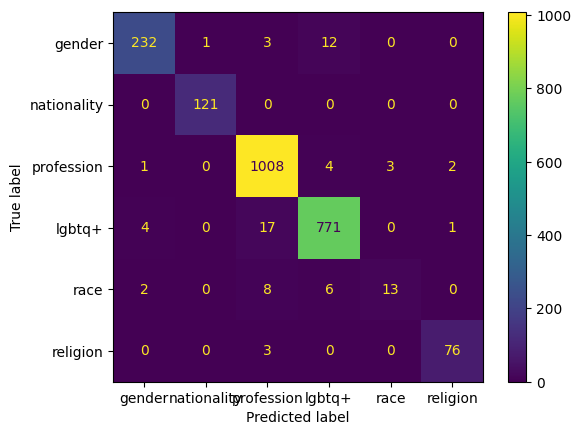

In [251]:
y_pred = lgb_model_ste.predict(X_vali)
print("\nClassification Report:")
print(classification_report(y_vali, y_pred))
print("F1 Score:")
print(f1_score(y_vali, y_pred, average='macro'))
print("Confusion Matrix:")
cm = confusion_matrix(y_vali, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=y_train.unique())
cmd.plot()

### Train with all the data

In [252]:
tracker_2 = EmissionsTracker()
tracker_2.start()
lgb_model_ste = lgb.LGBMClassifier(random_state=42, force_col_wise=True, min_data_in_leaf= min_data_in_leaf)
lgb_model_ste.fit(X, y)
emissions_ste = tracker_2.stop()
print(f"Training carbon emissions: {emissions_ste} kg")

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Total Bins 116713
[LightGBM] [Info] Number of data points in the train set: 45760, number of used features: 10713
[LightGBM] [Info] Start training from score -2,210180
[LightGBM] [Info] Start training from score -2,872911
[LightGBM] [Info] Start training from score -0,798896
[LightGBM] [Info] Start training from score -1,078643
[LightGBM] [Info] Start training from score -4,698079
[LightGBM] [Info] Start training from score -3,358419
Training carbon emissions: 5.6291124487932014e-05 kg


c:\Users\josem\Desktop\envs\llm\Lib\site-packages\codecarbon\output_methods\file.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


### Evaluate on Test

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

Classification Report:
              precision    recall  f1-score   support

      gender       0.96      0.92      0.94      1300
      lgbtq+       1.00      1.00      1.00       677
 nationality       0.98      0.99      0.99      5069
  profession       0.97      0.98      0.97      3849
        race       0.89      0.47      0.62        99
    religion       0.96      0.96      0.96       447

    accuracy                           0.97     11441
   macro avg       0.96      0.89      0.91     11441
weighted avg       0.97      0.97      0.97     11441

F1 Score:
0.9131561704023167


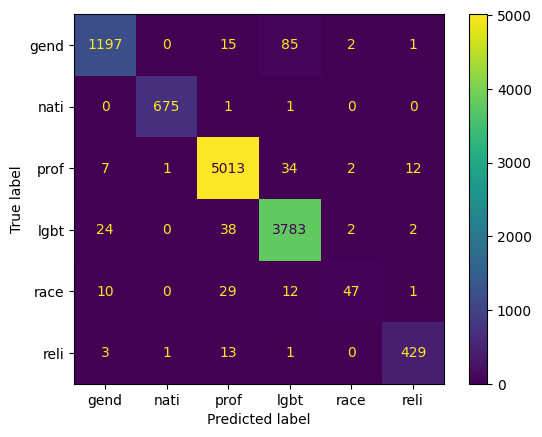

In [253]:
# 6. Evaluate
X_fidf_test = vectorizer_ste.transform(df_test['text'])
try:
    X_embedd_test = np.load('data/featurized_data/x_test_embedd.npy')
except Exception as e:
    print(e)
    X_embedd_test = model.encode(df_test['text'])
    np.save('data/featurized_data/x_test_embedd.npy', X_embedd_test)
X_test = hstack([X_fidf_test,test_similarity])
y_pred = lgb_model_ste.predict(X_test)
y_test = df_test[label].str.replace('unrelated','neutral')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score:")
print(f1_score(y_test, y_pred, average='macro'))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i[:4] for i in y_train.unique()])
cmd.plot()

## Category Model

### Vectorize

In [254]:
# Create TF-IDF features
label = 'category'
vectorizer = TfidfVectorizer()
X_fidf = vectorizer.fit_transform(df_train['text'])
X = hstack([X_fidf, train_similarity_cat, lgb_model_ste.predict_proba(hstack([vectorizer_ste.transform(df_train['text']), train_similarity]))])
y = df_train[label].str.replace('unrelated','neutral')

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


### Train and Validate Model

In [255]:
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.05, random_state=0)

In [256]:
min_data_in_leaf = 2
# Train LightGBM
lgb_model = lgb.LGBMClassifier(random_state = 42, force_col_wise = True)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14784, number of negative: 28688
[LightGBM] [Info] Total Bins 87111
[LightGBM] [Info] Number of data points in the train set: 43472, number of used features: 2247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,340081 -> initscore=-0,662933
[LightGBM] [Info] Start training from score -0,662933


LGBMClassifier(force_col_wise=True, random_state=42)


Classification Report:
              precision    recall  f1-score   support

     neutral       0.72      0.95      0.82      1475
  stereotype       0.79      0.34      0.48       813

    accuracy                           0.73      2288
   macro avg       0.76      0.65      0.65      2288
weighted avg       0.75      0.73      0.70      2288

F1 Score:
0.650524149462988
Confusion Matrix:


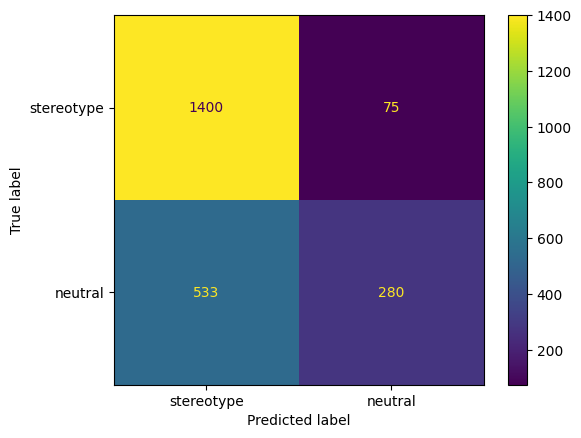

In [257]:
y_pred = lgb_model.predict(X_vali)
print("\nClassification Report:")
print(classification_report(y_vali, y_pred))
print("F1 Score:")
print(f1_score(y_vali, y_pred, average='macro'))
print("Confusion Matrix:")
cm = confusion_matrix(y_vali, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=y_train.unique())
cmd.plot()

### Train with all the data

In [258]:
tracker = EmissionsTracker()
tracker.start()
lgb_model_category = lgb.LGBMClassifier(random_state=42, force_col_wise=True)
lgb_model_category.fit(X, y)
emissions = tracker.stop()
print(f"Training carbon emissions: {emissions} kg")

[LightGBM] [Info] Number of positive: 15597, number of negative: 30163
[LightGBM] [Info] Total Bins 91180
[LightGBM] [Info] Number of data points in the train set: 45760, number of used features: 2328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,340844 -> initscore=-0,659537
[LightGBM] [Info] Start training from score -0,659537
Training carbon emissions: 7.086628566363753e-06 kg


### Evaluate on Test

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.93      0.83      7535
  stereotype       0.74      0.36      0.49      3906

    accuracy                           0.74     11441
   macro avg       0.74      0.65      0.66     11441
weighted avg       0.74      0.74      0.71     11441

F1 Score:
0.6559612182232907


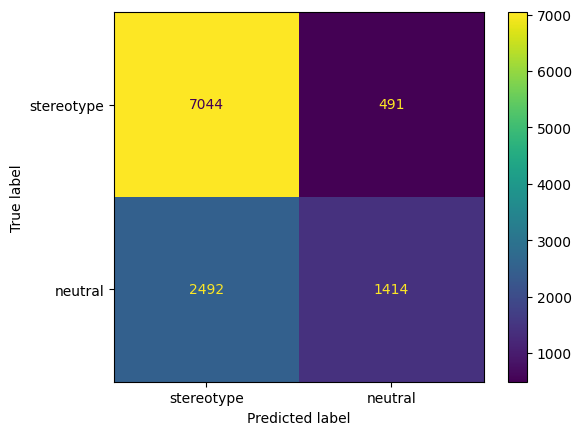

In [259]:
# 6. Evaluate
X_fidf_test = vectorizer.transform(df_test['text'])
X_test = hstack([X_fidf_test,test_similarity_cat,lgb_model_ste.predict_proba(hstack([vectorizer_ste.transform(df_test['text']), test_similarity]))])
y_pred = lgb_model_category.predict(X_test)
y_test = df_test[label].str.replace('unrelated','neutral')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score:")
print(f1_score(y_test, y_pred, average='macro'))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=y_train.unique())
cmd.plot()

# Total Emissions

In [260]:
total_emissions = emissions+emissions_ste
print(f'Total Emissions: {total_emissions}')

Total Emissions: 6.337775305429577e-05


# Usage Sample

In [261]:
start_time = time.time()

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
data = ["I don't understand why people can't just act normal these days. Sure, everyone has their quirks, but it's getting ridiculous. Like, not every gay guy needs to be so flamboyant and over-the-top about everything. Meanwhile, at work, my coworker keeps complaining about the cafeteria food—it’s not even that bad. And then there’s the neighbors who keep leaving their trash cans out after pickup. People really need to get their act together."]

sentences = pd.DataFrame(tokenizer.tokenize(data[0]), columns=['text'])
similarity_sentences = [{stype: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions[stype]['mean'].T).item() 
                    for stype in distributions} for text in sentences.text]
similarity_sentences = pd.DataFrame(similarity_sentences)
similarity_sentences_cat = [{cat: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions_cat[cat]['mean'].T).item() 
                    for cat in distributions_cat} for text in sentences.text]
similarity_sentences_cat = pd.DataFrame(similarity_sentences_cat)
X_sentences_ste = hstack([vectorizer_ste.transform(sentences.text),similarity_sentences])
X_sentences_cat = hstack([vectorizer.transform(sentences.text),similarity_sentences_cat, lgb_model_ste.predict_proba(hstack([vectorizer_ste.transform(sentences.text), similarity_sentences]))])
y_pred_cat = lgb_model_category.predict(X_sentences_cat)
y_pred_ste = lgb_model_ste.predict(X_sentences_ste)
for id_, text_ in enumerate(sentences.text):
    print('='*100)
    print(f"text: {text_}")
    print(f"Category: {y_pred_cat[id_]}")
    print(f"Stereotype Type: {y_pred_ste[id_]}")
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
text: I don't understand why people can't just act normal these days.
Category: neutral
Stereotype Type: gender
text: Sure, everyone has their quirks, but it's getting ridiculous.
Category: neutral
Stereotype Type: profession
text: Like, not every gay guy needs to be so flamboyant and over-the-top about everything.
Category: stereotype
Stereotype Type: gender
text: Meanwhile, at work, my coworker keeps complaining about the cafeteria food—it’s not even that bad.
Category: neutral
Stereotype Type: profession
text: And then there’s the neighbors who keep leaving their trash cans out after pickup.
Category: neutral
Stereotype Type: profession
text: People really need to get their act together.
Category: neutral
Stereotype Type: profession
--- 0.67900609

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


In [262]:
# Load the text classification pipeline
def assess_bias(model, counterfactuals):
    bias_results = {}
    for text in counterfactuals:
        prediction = model(text)
        bias_results[text] = prediction
    return bias_results


# Creating demographic counterfactuals (example)
counterfactuals = ["Black's usually think that the chef is talented.", "Asians often assume that the nurse is dedicated."]
for counter in counterfactuals:
    sentences = pd.DataFrame([counter], columns=['text'])
    similarity_counter = [{stype: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions[stype]['mean'].T).item() 
                        for stype in distributions} for text in sentences.text]
    similarity_counter = pd.DataFrame(similarity_counter)
    similarity_counter_cat = [{cat: cosine_similarity(model.encode(text).reshape(-1,1).T, distributions_cat[cat]['mean'].T).item() 
                        for cat in distributions_cat} for text in sentences.text]
    similarity_counter_cat = pd.DataFrame(similarity_counter_cat)
    X_counter_cat = hstack([vectorizer.transform(sentences.text),similarity_counter_cat,lgb_model_ste.predict_proba(hstack([vectorizer_ste.transform(sentences.text), similarity_counter]))])
    X_counter_ste = hstack([vectorizer_ste.transform(sentences.text),similarity_counter])
    y_pred_cat = lgb_model_category.predict(X_counter_cat)
    y_pred_ste = lgb_model_ste.predict(X_counter_ste)
    y_pred_cat_prob = lgb_model_category.predict_proba(X_counter_cat)
    y_pred_ste_prob = lgb_model_ste.predict_proba(X_counter_ste)
    print('='*100)
    print(f"text: {counter}")
    print(f"Category: {y_pred_cat}, Probabilities: {y_pred_cat_prob}")
    print(f"Stereotype Type: {y_pred_ste}, Probabilities: {y_pred_ste_prob}")

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
text: Black's usually think that the chef is talented.
Category: ['stereotype'], Probabilities: [[0.19751024 0.80248976]]
Stereotype Type: ['profession'], Probabilities: [[1.65889435e-03 3.84202106e-06 9.45903403e-03 9.88580114e-01
  1.59078602e-04 1.39036604e-04]]
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
text: Asians o

c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
c:\Users\josem\Desktop\envs\llm\Lib\site-packages\lightgbm\basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
